<a href="https://colab.research.google.com/github/Talha-Swati/HQSR/blob/main/Direct_Speech_Recogntion_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
import os
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [31]:
# Paths for Google Colab
audio_folder = "/drive/MyDrive/fyp/All surah audio"
csv_path = "/content/Allsurah.csv"  # CSV file uploaded to Colab's temporary storage

In [32]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [36]:
# Function to extract features from audio files
def extract_features(y, sr):
    try:
        # MFCCs
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        # Spectral Contrast
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        # Mel Spectrogram
        mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40).T, axis=0)
        # Chroma Features
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        features = np.concatenate((mfccs, spectral_contrast, mel_spectrogram, chroma))
        return features
    except Exception as e:
        print(f"Error extracting features: {str(e)}")
        return np.array([])

In [34]:
# Load the CSV file for the Holy Qur'an audio data
df = pd.read_csv(csv_path)

# Prepare data
features, labels = [], []

for index, row in df.iterrows():
    file_name = os.path.join(audio_folder, f"{row['name']}.wav")
    class_label = row['label']

    if os.path.exists(file_name):
        y, sr = librosa.load(file_name, sr=None)
        data = extract_features(y, sr)
        if len(data) > 0:
            features.append(data)
            labels.append(class_label)

if len(labels) == 0:
    raise ValueError("No labels found. Please check your data.")

# Encode the classification labels
le = LabelEncoder()
labels_encoded = to_categorical(le.fit_transform(labels))

# Convert to NumPy arrays
X = np.array(features)
y = np.array(labels_encoded)

# Print information
print(f"Features array shape: {X.shape}")  # (num_samples, num_features)
print(f"Labels array shape: {y.shape}")    # (num_samples, num_classes)
print(f"Label distribution before SMOTE: {Counter(labels)}")

Features array shape: (1320, 72)
Labels array shape: (1320, 23)
Label distribution before SMOTE: Counter({'N': 881, 'rehman rehim': 20, 'taynaka kawthar': 20, 'Fa-salli wanhar': 20, "shani'aka": 20, 'Qul Ahad': 20, 'Samad': 20, 'yoolad': 20, 'yakun-lahu ahad': 20, 'yadkhuloona deen': 20, 'Fasabbih bihamdi': 20, "Qul a'udhu": 20, 'Maliki': 20, 'Ilahi': 20, 'khannas': 20, ' yuwaswisu sudoorin': 20, 'jinnati': 20, "Qul a'udhu falaq": 20, 'khalaq': 20, 'waqab': 20, 'naffathati': 20, 'hasidin hasad': 20, 'nasru': 19})


In [37]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, np.argmax(y, axis=1))

# Convert resampled labels back to one-hot encoding
y_resampled = to_categorical(y_resampled, num_classes=y.shape[1])

# Normalize the features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Dimensionality Reduction (PCA)
pca = PCA(n_components=50)
X_resampled = pca.fit_transform(X_resampled)

# Print the results
print("Resampled features array shape:", X_resampled.shape)
print("Resampled label array shape:", y_resampled.shape)

Resampled features array shape: (20263, 50)
Resampled label array shape: (20263, 23)


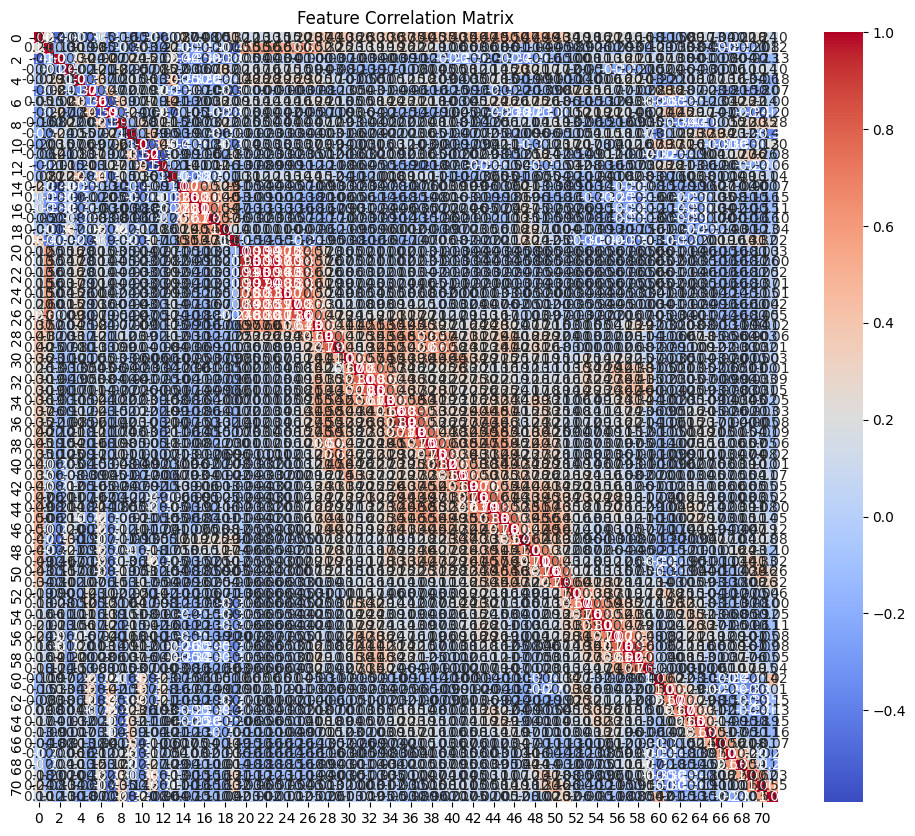

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Suppose X is your feature matrix (samples x features)
df_features = pd.DataFrame(X)
corr = df_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()
#Calculate the correlation coefficients between all pairs of features.
#If two features have a high correlation (close to +1 or -1), they are likely redundant.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Suppose X is your feature matrix with shape (samples, features)
# Convert to DataFrame for easier handling
df_features = pd.DataFrame(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = df_features.columns
vif_data["VIF"] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]

print(vif_data)
#VIF measures how much a feature is explained by other features
#High VIF means the feature is redundant

    feature        VIF
0         0  97.872634
1         1  21.249820
2         2  10.244106
3         3   2.351890
4         4  16.886538
..      ...        ...
67       67  41.029723
68       68  40.443387
69       69  40.854198
70       70  34.181024
71       71  27.473899

[72 rows x 2 columns]


In [ ]:
# Reshape for LSTM input (samples, timesteps, features)
X_resampled = np.expand_dims(X_resampled, axis=2)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    LSTM(128, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(23, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Cross-validation (Stratified KFold)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=16, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 79s 91ms/step - accuracy: 0.0851 - loss: 3.3678 - val_accuracy: 0.1897 - val_loss: 2.7698
Epoch 2/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.1759 - loss: 2.7728 - val_accuracy: 0.2677 - val_loss: 2.4319
Epoch 3/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.2651 - loss: 2.4737 - val_accuracy: 0.3683 - val_loss: 2.2004
Epoch 4/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 80s 93ms/step - accuracy: 0.3587 - loss: 2.2017 - val_accuracy: 0.4556 - val_loss: 1.9075
Epoch 5/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 80s 91ms/step - accuracy: 0.4419 - loss: 1.9271 - val_accuracy: 0.5845 - val_loss: 1.5959
Epoch 6/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.5026 - loss: 1.7553 - val_accuracy: 0.6107 - val_loss: 1.4692
Epoch 7/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.5607 - loss: 1.5984 - val_accuracy: 0.6712 - val_loss: 1.2466
Epoch 8/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.6172 - loss: 1.4082 - 

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,335 (2.30 MB)

 Trainable params: 201,111 (785.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 402,224 (1.53 MB)

In [ ]:
train_accuracies = []
val_accuracies = []

# Inside your cross-validation loop, after model.fit():
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

train_accuracies.append(train_acc)
val_accuracies.append(val_acc)

# After the KFold loop ends:
print(f"\nAverage Training Accuracy: {np.mean(train_accuracies):.4f}")
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.4f}")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")



Average Training Accuracy: 0.9346
Average Validation Accuracy: 0.9540
Test Accuracy: 0.9351


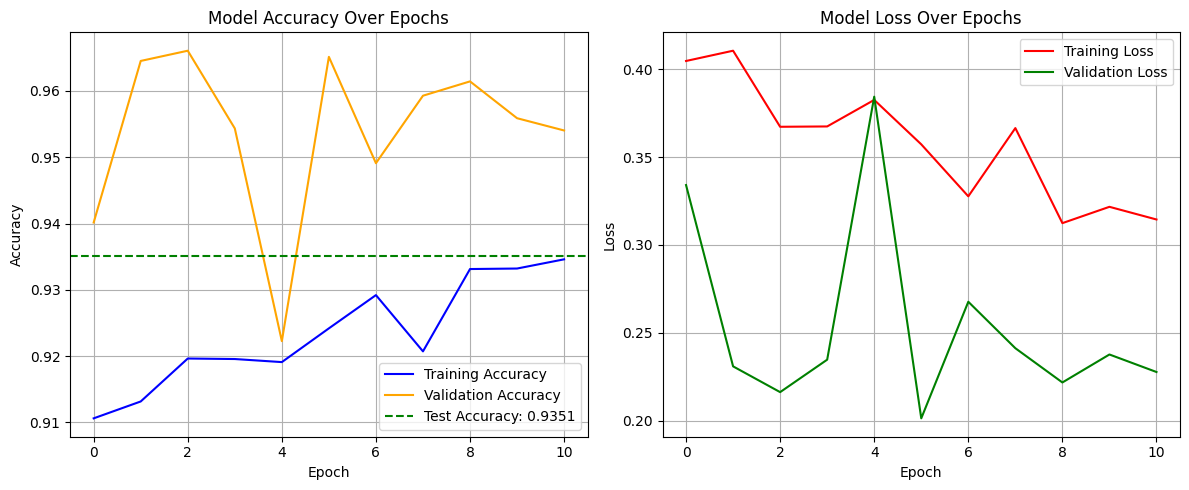

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Accuracy: {test_accuracy:.4f}')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step
Classification Report:

                     precision    recall  f1-score   support

 yuwaswisu sudoorin       0.88      0.99      0.93       159
    Fa-salli wanhar       0.98      0.95      0.97       193
   Fasabbih bihamdi       0.84      0.95      0.89       177
              Ilahi       0.98      0.87      0.92       191
             Maliki       0.95      0.97      0.96       177
                  N       0.91      0.88      0.89       150
           Qul Ahad       0.96      0.91      0.93       179
         Qul a'udhu       0.89      0.91      0.90       167
   Qul a'udhu falaq       0.95      0.94      0.95       199
              Samad       0.98      0.90      0.94       181
      hasidin hasad       0.97      0.95      0.96       163
            jinnati       0.97      0.91      0.94       176
             khalaq       0.95      0.93      0.94       167
            khannas       0.93      0.97      0.95       175
         naffathat

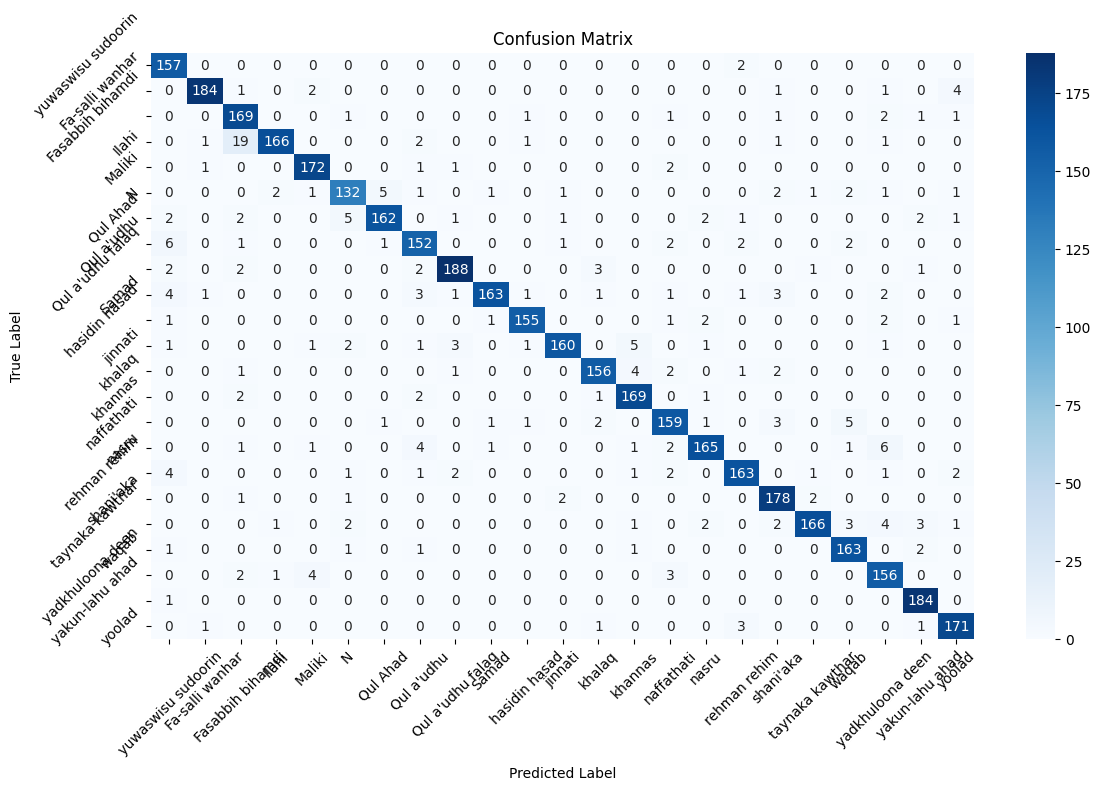

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict class labels for the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
target_names = le.classes_  # From your LabelEncoder
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Save the fitted scaler, PCA, and label encoder
joblib.dump(scaler, '/content/scaler.pkl')
joblib.dump(pca, '/content/pca.pkl')
joblib.dump(le, '/content/label_encoder.pkl')


['/content/label_encoder.pkl']

In [ ]:
import os
import tensorflow as tf

# Assuming your model is already created and trained, save the model in Keras format
keras_model_path = '/content/audio_classification_modelPCA.keras'
model.save(keras_model_path)

# TFLite Conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = '/content/audio_classification_modelPCA.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Check if the TFLite model was saved correctly
if os.path.exists(tflite_model_path):
    print(f"✅ TFLite model saved successfully at {tflite_model_path}")
else:
    print(f"❌ Error: TFLite model was not saved. Check the conversion process.")


Saved artifact at '/tmp/tmp7c75l1eu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 1), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 23), dtype=tf.float32, name=None)
Captures:
  135666964338192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666964335120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666964333392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666964334736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666964339344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666964339152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666964337616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666964338960: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite model saved successfully at /content/audio_classification_modelPCA.tflite


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving fi5.wav to fi5.wav


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving n6.5.wav to n6.5.wav


In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import joblib  # Used to load scaler, pca, and label encoder
from tensorflow.keras.utils import to_categorical

# Load scaler, PCA, and label encoder (you must have saved them during training)
scaler = joblib.load('/content/scaler.pkl')
pca = joblib.load('/content/pca.pkl')
le = joblib.load('/content/label_encoder.pkl')

# Path to your test audio file
test_audio_path = '/content/fi5.wav'

# Feature extraction function (same as training)
def extract_features_for_prediction(y, sr):
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    return np.concatenate((mfccs, spectral_contrast, mel_spectrogram, chroma))

# Load and preprocess audio
y, sr = librosa.load(test_audio_path, sr=None)
features = extract_features_for_prediction(y, sr)

# Scale and apply PCA
features_scaled = scaler.transform([features])
features_pca = pca.transform(features_scaled)

# Reshape for LSTM input in TFLite (samples, timesteps, features)
input_data = np.expand_dims(features_pca, axis=2).astype(np.float32)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/audio_classification_modelPCA.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_index = np.argmax(output_data)
predicted_label = le.inverse_transform([predicted_index])[0]

print("Predicted Label:", predicted_label)


Predicted Label: hasidin hasad


In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import joblib  # Used to load scaler, pca, and label encoder
from tensorflow.keras.utils import to_categorical

# Load scaler, PCA, and label encoder (you must have saved them during training)
scaler = joblib.load('/content/scaler.pkl')
pca = joblib.load('/content/pca.pkl')
le = joblib.load('/content/label_encoder.pkl')

# Path to your test audio file
test_audio_path = '/content/nri2.wav'

# Feature extraction function (same as training)
def extract_features_for_prediction(y, sr):
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    return np.concatenate((mfccs, spectral_contrast, mel_spectrogram, chroma))

# Load and preprocess audio
y, sr = librosa.load(test_audio_path, sr=None)
features = extract_features_for_prediction(y, sr)

# Scale and apply PCA
features_scaled = scaler.transform([features])
features_pca = pca.transform(features_scaled)

# Reshape for LSTM input in TFLite (samples, timesteps, features)
input_data = np.expand_dims(features_pca, axis=2).astype(np.float32)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/audio_classification_modelPCA.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_index = np.argmax(output_data)
predicted_label = le.inverse_transform([predicted_index])[0]

print("Predicted Label:", predicted_label)


Predicted Label: yadkhuloona deen


In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import joblib  # Used to load scaler, pca, and label encoder
from tensorflow.keras.utils import to_categorical

# Load scaler, PCA, and label encoder (you must have saved them during training)
scaler = joblib.load('/content/scaler.pkl')
pca = joblib.load('/content/pca.pkl')
le = joblib.load('/content/label_encoder.pkl')

# Path to your test audio file
test_audio_path = '/content/n6.5.wav'

# Feature extraction function (same as training)
def extract_features_for_prediction(y, sr):
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    return np.concatenate((mfccs, spectral_contrast, mel_spectrogram, chroma))

# Load and preprocess audio
y, sr = librosa.load(test_audio_path, sr=None)
features = extract_features_for_prediction(y, sr)

# Scale and apply PCA
features_scaled = scaler.transform([features])
features_pca = pca.transform(features_scaled)

# Reshape for LSTM input in TFLite (samples, timesteps, features)
input_data = np.expand_dims(features_pca, axis=2).astype(np.float32)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/audio_classification_modelPCA.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_index = np.argmax(output_data)
predicted_label = le.inverse_transform([predicted_index])[0]

print("Predicted Label:", predicted_label)


Predicted Label: N
